In [1]:
import wandb
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools

In [2]:
### Config
project = "lr-extrapolate-noisy2"

# use_cache = False
use_cache = True
# TOP_K_RUNS = 1000
TOP_K_RUNS = 1
STEP = "last"  # 'best', 'last', or 'tok32'

# when exporting from wandb, limit the number of runs for fast debugging
max_runs = 10000
# max_runs = 100

if project == "lr-extrapolate-noisy2":
    DIFF = "data.curriculum.dims.end"
    XYS_TRAIN = "data.curriculum.points_train.end"
    XYS_VAL = "data.curriculum.points_val.end"
    METRIC = "Mean Squared Error"
    METRIC_TOK_VAL = "eval-eval.per_token_loss"
    METRIC_TOK_TEST = "eval-test.per_token_loss"
    METRIC_AVG_VAL = "eval-eval.loss"
    METRIC_AVG_TEST = "eval-test.loss"
    METRIC_MAX_MIN = "min"  # 'max' or 'min
    n_classes = [(0, 0), (0, 0.1), (0, 0.5), (0, 1)]
else:
    raise ValueError(f"Unknown project: {project}")


states = ("finished",)
entity = "iceberg"
hist_cols = [
    METRIC_TOK_VAL,
    METRIC_TOK_TEST,
    METRIC_AVG_VAL,
    METRIC_AVG_TEST,
    # "data.train_noise",
    # "data.val_noise",
]
config_cols = ["model", DIFF, XYS_TRAIN, "data.train_noise", "data.val_noise"]

In [3]:
def get_wandb_runs(entity, project):
    api = wandb.Api()
    runs = api.runs(f"{entity}/{project}")
    return runs

def extract_pow2_accs(x):
    pows = [int(2**i) - 1 for i in range(11)]
    extracted_accs = x[pows]
    return extracted_accs

def compute_avg_acc(x):
    return np.mean(x)

def build_fp(**kwargs):
    return "_".join([f"{k}={v}" for k, v in kwargs.items()]) + ".pkl"


def export_wandb_project(
    entity,
    project,
    config_cols,
    hist_cols,
    max_runs=None,
    states=("finished"),
    use_cache=False,
):
    fp = build_fp(entity=entity, project=project)
    if use_cache:
        try:
            print(f"Attempting to load cache file: {fp}")
            return pd.read_pickle(fp)
        except FileNotFoundError:
            print(f"Cache file not found: {fp}. Exporting from wandb.")
            pass

    runs = get_wandb_runs(entity, project)
    print(f"{runs[0].__dict__.keys()}=")
    run_data = []

    for run in tqdm(runs, desc="Exporting run data"):
        if (max_runs is not None) and (len(run_data) >= max_runs):
            break

        if run.state not in states:
            continue

        id = {"run_id": run.id, "sweep_id": str(run.sweep)}
        config = {k: run.config.get(k) for k in config_cols}
        config.update(id)
        hist = run.history(keys=hist_cols)

        # Combine all information and history data
        # combined_data = pd.concat([id, config, hist], axis=1)
        combined_data = hist.assign(**config)

        # Append the combined data to run_data list
        run_data.append(combined_data)

    # Combine all run data into a single DataFrame
    all_run_data = pd.concat(run_data, ignore_index=True)

    all_run_data.to_pickle(fp)
    return all_run_data


df = export_wandb_project(
    entity=entity,
    project=project,
    config_cols=config_cols,
    hist_cols=hist_cols,
    max_runs=max_runs,
    states=states,
    use_cache=use_cache,
)
print(df.shape)
df.head()

Attempting to load cache file: entity=iceberg_project=lr-extrapolate-noisy2.pkl


(44184, 12)


,_step,eval-eval.per_token_loss,eval-test.per_token_loss,eval-eval.loss,eval-test.loss,model,data.curriculum.dims.end,data.curriculum.points_train.end,data.train_noise,data.val_noise,run_id,sweep_id
0,0,"[18.97379493713379, 20.421985626220703, 19.216...","[19.548969268798828, 20.69211769104004, 19.181...",19.957048,20.158054,s4,20,32,0.0,0.0,3wxeqgrj,<Sweep iceberg/lr-extrapolate-noisy2/0mzwif76 ...
1,5000,"[18.96276092529297, 20.38445281982422, 19.2646...","[19.513830184936523, 20.654754638671875, 19.10...",19.847815,20.041954,s4,20,32,0.0,0.0,3wxeqgrj,<Sweep iceberg/lr-extrapolate-noisy2/0mzwif76 ...
2,10000,"[18.971660614013672, 20.100841522216797, 19.04...","[19.525211334228516, 20.362136840820312, 18.84...",20.010649,20.165979,s4,20,32,0.0,0.0,3wxeqgrj,<Sweep iceberg/lr-extrapolate-noisy2/0mzwif76 ...
3,15000,"[18.990144729614258, 19.756668090820312, 18.60...","[19.57090187072754, 19.96059226989746, 18.6499...",19.664392,19.781492,s4,20,32,0.0,0.0,3wxeqgrj,<Sweep iceberg/lr-extrapolate-noisy2/0mzwif76 ...
4,20000,"[18.94953155517578, 19.5709228515625, 18.41873...","[19.505165100097656, 19.898500442504883, 18.56...",19.655981,19.848244,s4,20,32,0.0,0.0,3wxeqgrj,<Sweep iceberg/lr-extrapolate-noisy2/0mzwif76 ...


In [4]:
# add column for token metric at index 32
df['val_metric_tok32'] = df[METRIC_TOK_VAL].apply(lambda x: x[31])
df['test_metric_tok32'] = df[METRIC_TOK_TEST].apply(lambda x: x[31])
df.head()

,_step,eval-eval.per_token_loss,eval-test.per_token_loss,eval-eval.loss,eval-test.loss,model,data.curriculum.dims.end,data.curriculum.points_train.end,data.train_noise,data.val_noise,run_id,sweep_id,val_metric_tok32,test_metric_tok32
0,0,"[18.97379493713379, 20.421985626220703, 19.216...","[19.548969268798828, 20.69211769104004, 19.181...",19.957048,20.158054,s4,20,32,0.0,0.0,3wxeqgrj,<Sweep iceberg/lr-extrapolate-noisy2/0mzwif76 ...,19.088869,20.391825
1,5000,"[18.96276092529297, 20.38445281982422, 19.2646...","[19.513830184936523, 20.654754638671875, 19.10...",19.847815,20.041954,s4,20,32,0.0,0.0,3wxeqgrj,<Sweep iceberg/lr-extrapolate-noisy2/0mzwif76 ...,19.017986,20.101162
2,10000,"[18.971660614013672, 20.100841522216797, 19.04...","[19.525211334228516, 20.362136840820312, 18.84...",20.010649,20.165979,s4,20,32,0.0,0.0,3wxeqgrj,<Sweep iceberg/lr-extrapolate-noisy2/0mzwif76 ...,18.072699,18.699404
3,15000,"[18.990144729614258, 19.756668090820312, 18.60...","[19.57090187072754, 19.96059226989746, 18.6499...",19.664392,19.781492,s4,20,32,0.0,0.0,3wxeqgrj,<Sweep iceberg/lr-extrapolate-noisy2/0mzwif76 ...,17.662191,18.260622
4,20000,"[18.94953155517578, 19.5709228515625, 18.41873...","[19.505165100097656, 19.898500442504883, 18.56...",19.655981,19.848244,s4,20,32,0.0,0.0,3wxeqgrj,<Sweep iceberg/lr-extrapolate-noisy2/0mzwif76 ...,16.333054,17.134130


In [5]:
df['model'].value_counts()

model
s4             3402
rwkv           3402
llama2         3402
gpt2           3402
retnet         3402
mamba          3402
hyena          3402
h3             3402
lightconv      3402
gru            3402
lstm           3402
rnn            3402
dynamicconv    3360
Name: count, dtype: int64

In [6]:
def pick_step(df, row_type, max_min):
    # group df by run_id
    grouped_df = df.groupby('run_id')
    
    if row_type == 'last':
        # only keep the last row of each group
        df = grouped_df.last()
        df = df.reset_index(drop=False)    
    elif row_type == 'best':
        # only keep the row with the highest "eval-eval.avg_acc"
        if max_min == 'max':
            df = grouped_df.apply(lambda x: x.loc[x[METRIC_AVG_VAL].idxmax()])
        elif max_min == 'min':
            df = grouped_df.apply(lambda x: x.loc[x[METRIC_AVG_VAL].idxmin()])
        else:
            raise ValueError(f"Invalid max_min: {max_min}")
    elif row_type == 'tok32':
        if max_min == 'max':
            df = grouped_df.apply(lambda x: x.loc[x['val_metric_tok32'].idxmax()])
        elif max_min == 'min':
            df = grouped_df.apply(lambda x: x.loc[x['val_metric_tok32'].idxmin()])
    else:
        raise ValueError(f"Invalid row_type: {row_type}")

    # clean up the index
    
    return df
    
df_step = pick_step(df, row_type=STEP, max_min=METRIC_MAX_MIN)
print(df_step.shape)
df_step.head()

(2104, 14)


,run_id,_step,eval-eval.per_token_loss,eval-test.per_token_loss,eval-eval.loss,eval-test.loss,model,data.curriculum.dims.end,data.curriculum.points_train.end,data.train_noise,data.val_noise,sweep_id,val_metric_tok32,test_metric_tok32
0,0149gr12,100000,"[18.941905975341797, 19.193044662475586, 17.47...","[19.536907196044922, 19.452341079711914, 17.26...",38.772728,37.858139,gpt2,20,32,0.0,1.0,<Sweep iceberg/lr-extrapolate-noisy2/e7s86bm1 ...,2.633275,2.800241
1,015b4csx,100000,"[18.936386108398438, 20.384422302246094, 19.23...","[19.520288467407227, 20.730079650878906, 19.16...",19.943569,20.154739,dynamicconv,20,32,0.0,0.5,<Sweep iceberg/lr-extrapolate-noisy2/c1yc2ius ...,19.082409,20.326277
2,023vlp6q,100000,"[18.935440063476562, 20.190452575683594, 19.08...","[19.520931243896484, 20.723031997680664, 19.00...",19.285301,19.495152,lightconv,20,32,0.1,0.0,<Sweep iceberg/lr-extrapolate-noisy2/0mzwif76 ...,18.547569,19.771341
3,026xbj5b,100000,"[18.951467514038086, 20.2210693359375, 19.2664...","[19.51494598388672, 20.457551956176758, 18.984...",18.412216,18.488518,dynamicconv,20,32,0.0,1.0,<Sweep iceberg/lr-extrapolate-noisy2/e7s86bm1 ...,18.029945,18.487568
4,04cnk8q6,100000,"[18.94397735595703, 20.353168487548828, 19.167...","[19.52032470703125, 20.6446533203125, 18.99348...",19.301426,19.416115,lightconv,20,32,0.0,0.0,<Sweep iceberg/lr-extrapolate-noisy2/0mzwif76 ...,18.505564,19.956356


In [7]:
df_step['model'].value_counts()

model
gpt2           162
lightconv      162
rwkv           162
rnn            162
llama2         162
gru            162
mamba          162
lstm           162
s4             162
h3             162
hyena          162
retnet         162
dynamicconv    160
Name: count, dtype: int64

In [8]:
df_step[df_step['model'] == 'rwkv'].sort_values('_step', ascending=True).head()

,run_id,_step,eval-eval.per_token_loss,eval-test.per_token_loss,eval-eval.loss,eval-test.loss,model,data.curriculum.dims.end,data.curriculum.points_train.end,data.train_noise,data.val_noise,sweep_id,val_metric_tok32,test_metric_tok32
5,04kyzdc8,100000,"[18.95688247680664, 19.058446884155273, 17.335...","[19.519269943237305, 19.313772201538086, 17.10...",1.917044,1.938961,rwkv,20,32,0.1,0.1,<Sweep iceberg/lr-extrapolate-noisy2/eotbqdvu ...,5.174655,5.482486
1336,m4z7rij6,100000,"[18.939777374267578, 18.975919723510742, 17.28...","[19.525226593017578, 19.255359649658203, 17.08...",6.672655,6.764711,rwkv,20,32,0.1,0.1,<Sweep iceberg/lr-extrapolate-noisy2/eotbqdvu ...,3.007712,3.052546
1350,meeqkjt5,100000,"[18.939777374267578, 18.9858455657959, 17.2840...","[19.525226593017578, 19.252626419067383, 17.07...",6.669396,6.761013,rwkv,20,32,0.1,0.0,<Sweep iceberg/lr-extrapolate-noisy2/eotbqdvu ...,2.995454,3.018257
1359,mmh441gu,100000,"[18.952367782592773, 19.01576805114746, 17.351...","[19.5261173248291, 19.351343154907227, 17.0726...",2.287714,2.317877,rwkv,20,32,0.1,0.0,<Sweep iceberg/lr-extrapolate-noisy2/eotbqdvu ...,4.318054,4.304917
1391,n9dk8tnt,100000,"[18.939167022705078, 19.004825592041016, 17.33...","[19.522253036499023, 19.28713607788086, 17.138...",5.891658,5.917199,rwkv,20,32,0.0,0.1,<Sweep iceberg/lr-extrapolate-noisy2/eotbqdvu ...,4.522552,4.634652


In [9]:
df_step['sweep_id'].value_counts()

sweep_id
<Sweep iceberg/lr-extrapolate-noisy2/0mzwif76 (FINISHED)>    1294
<Sweep iceberg/lr-extrapolate-noisy2/e7s86bm1 (FINISHED)>     324
<Sweep iceberg/lr-extrapolate-noisy2/c1yc2ius (FINISHED)>     324
<Sweep iceberg/lr-extrapolate-noisy2/eotbqdvu (FINISHED)>     108
<Sweep iceberg/lr-extrapolate-noisy2/fvd0ntq6 (FINISHED)>      27
<Sweep iceberg/lr-extrapolate-noisy2/0xcphgb3 (FINISHED)>      27
Name: count, dtype: int64

In [10]:
df_step['_step'].value_counts()

_step
100000    2104
Name: count, dtype: int64

In [11]:
# show rows where _step isnt 100000
df_step[df_step['_step'] != 100000]

,run_id,_step,eval-eval.per_token_loss,eval-test.per_token_loss,eval-eval.loss,eval-test.loss,model,data.curriculum.dims.end,data.curriculum.points_train.end,data.train_noise,data.val_noise,sweep_id,val_metric_tok32,test_metric_tok32


In [12]:
# check for nan losses
df_step['eval-eval.loss'] = df_step['eval-eval.loss'].apply(lambda x: float(x))
_ = df_step.sort_values(by='eval-eval.loss', ascending=True)
_["eval-eval.loss"].head()

2038    0.705241
824     0.722115
1941    0.733001
1628    0.777749
339     0.908547
Name: eval-eval.loss, dtype: float64

In [13]:
_["eval-eval.loss"].tail()

1853    165.250778
1511    246.768234
1499    247.911545
1773    248.459854
46      256.161011
Name: eval-eval.loss, dtype: float64

In [14]:
def top_k_rows(group, k, metric_column, min_max):
    if min_max == 'max':
        return group.nlargest(k, metric_column)
    elif min_max == 'min':
        return group.nsmallest(k, metric_column)
    else:
        raise ValueError(f"Invalid min_max: {min_max}")
grouped = df_step.groupby(['model', DIFF, XYS_TRAIN, 'data.train_noise', 'data.val_noise']).apply(top_k_rows, k=TOP_K_RUNS, metric_column="val_metric_tok32", min_max=METRIC_MAX_MIN).reset_index(drop=True)
print(grouped.shape)
grouped.head()

(78, 14)


,run_id,_step,eval-eval.per_token_loss,eval-test.per_token_loss,eval-eval.loss,eval-test.loss,model,data.curriculum.dims.end,data.curriculum.points_train.end,data.train_noise,data.val_noise,sweep_id,val_metric_tok32,test_metric_tok32
0,q12l4wto,100000,"[18.953828811645508, 19.97625160217285, 18.638...","[19.53661346435547, 20.40018081665039, 18.5116...",17.375711,17.473192,dynamicconv,20,32,0.0,0.0,<Sweep iceberg/lr-extrapolate-noisy2/0mzwif76 ...,16.771097,17.747070
1,d5b04t3r,100000,"[18.936622619628906, 19.41357421875, 17.981575...","[19.586788177490234, 19.819782257080078, 18.64...",16.008186,16.136175,dynamicconv,20,32,0.0,0.1,<Sweep iceberg/lr-extrapolate-noisy2/0mzwif76 ...,15.684922,15.969107
2,c9xdv4y3,100000,"[18.940353393554688, 19.986173629760742, 18.64...","[19.5340518951416, 20.406339645385742, 18.5417...",17.399736,17.491098,dynamicconv,20,32,0.0,0.5,<Sweep iceberg/lr-extrapolate-noisy2/c1yc2ius ...,16.821337,17.718721
3,13ys2x1y,100000,"[18.95339012145996, 19.98715591430664, 18.7095...","[19.518266677856445, 20.469736099243164, 18.89...",17.914528,18.034529,dynamicconv,20,32,0.0,1.0,<Sweep iceberg/lr-extrapolate-noisy2/e7s86bm1 ...,17.151283,18.238644
4,np16hrvf,100000,"[18.94666290283203, 19.79901885986328, 18.0752...","[19.564136505126953, 20.110023498535156, 18.50...",16.113115,16.235983,dynamicconv,20,32,0.1,0.0,<Sweep iceberg/lr-extrapolate-noisy2/0mzwif76 ...,15.515574,16.053648


In [15]:
grouped['model'].value_counts()

model
dynamicconv    6
gpt2           6
gru            6
h3             6
hyena          6
lightconv      6
llama2         6
lstm           6
mamba          6
retnet         6
rnn            6
rwkv           6
s4             6
Name: count, dtype: int64

In [16]:
def agg_df(grouped):
    grouped = grouped.groupby(['model', DIFF, XYS_TRAIN, 'data.train_noise', 'data.val_noise']).agg({METRIC_TOK_VAL: list, METRIC_TOK_TEST: list, '_step': list})
    grouped[METRIC_TOK_VAL] = grouped[METRIC_TOK_VAL].apply(lambda x: np.mean(np.array(x), axis=0))
    grouped[METRIC_TOK_TEST] = grouped[METRIC_TOK_TEST].apply(lambda x: np.mean(np.array(x), axis=0))
    return grouped

df_agg = agg_df(grouped)
df_agg = df_agg.reset_index()
print(df_agg.shape)
df_agg.head()

(78, 8)


,model,data.curriculum.dims.end,data.curriculum.points_train.end,data.train_noise,data.val_noise,eval-eval.per_token_loss,eval-test.per_token_loss,_step
0,dynamicconv,20,32,0.0,0.0,"[18.953828811645508, 19.97625160217285, 18.638...","[19.53661346435547, 20.40018081665039, 18.5116...",[100000]
1,dynamicconv,20,32,0.0,0.1,"[18.936622619628906, 19.41357421875, 17.981575...","[19.586788177490234, 19.819782257080078, 18.64...",[100000]
2,dynamicconv,20,32,0.0,0.5,"[18.940353393554688, 19.986173629760742, 18.64...","[19.5340518951416, 20.406339645385742, 18.5417...",[100000]
3,dynamicconv,20,32,0.0,1.0,"[18.95339012145996, 19.98715591430664, 18.7095...","[19.518266677856445, 20.469736099243164, 18.89...",[100000]
4,dynamicconv,20,32,0.1,0.0,"[18.94666290283203, 19.79901885986328, 18.0752...","[19.564136505126953, 20.110023498535156, 18.50...",[100000]


In [17]:
def post_process(df):
    df = df.copy()
    # df['per_token_acc'] = df['per_token_acc'].apply(np.array)
    df['val_tok_len'] = df[METRIC_TOK_VAL].apply(len)
    df['test_tok_len'] = df[METRIC_TOK_TEST].apply(len)
    
    df['val_tok_pow2'] = df[METRIC_TOK_VAL].apply(extract_pow2_accs)
    df['test_tok_pow2'] = df[METRIC_TOK_TEST].apply(extract_pow2_accs)

    df['val_tok_pow2_len'] = df['val_tok_pow2'].apply(len)
    df['test_tok_pow2_len'] = df['test_tok_pow2'].apply(len)
    
    df['val_avg_acc'] = df[METRIC_TOK_VAL].apply(compute_avg_acc)
    df['test_avg_acc'] = df[METRIC_TOK_TEST].apply(compute_avg_acc)
    
    return df
df_agg = post_process(df_agg)
print(df_agg.shape)
df_agg

(78, 16)


,model,data.curriculum.dims.end,data.curriculum.points_train.end,data.train_noise,data.val_noise,eval-eval.per_token_loss,eval-test.per_token_loss,_step,val_tok_len,test_tok_len,val_tok_pow2,test_tok_pow2,val_tok_pow2_len,test_tok_pow2_len,val_avg_acc,test_avg_acc
0,dynamicconv,20,32,0.0,0.0,"[18.953828811645508, 19.97625160217285, 18.638...","[19.53661346435547, 20.40018081665039, 18.5116...",[100000],1024,1024,"[18.953828811645508, 19.97625160217285, 18.133...","[19.53661346435547, 20.40018081665039, 19.2627...",11,11,17.375712,17.473192
1,dynamicconv,20,32,0.0,0.1,"[18.936622619628906, 19.41357421875, 17.981575...","[19.586788177490234, 19.819782257080078, 18.64...",[100000],1024,1024,"[18.936622619628906, 19.41357421875, 17.836635...","[19.586788177490234, 19.819782257080078, 19.04...",11,11,16.008187,16.136174
2,dynamicconv,20,32,0.0,0.5,"[18.940353393554688, 19.986173629760742, 18.64...","[19.5340518951416, 20.406339645385742, 18.5417...",[100000],1024,1024,"[18.940353393554688, 19.986173629760742, 18.08...","[19.5340518951416, 20.406339645385742, 19.2889...",11,11,17.399737,17.491097
3,dynamicconv,20,32,0.0,1.0,"[18.95339012145996, 19.98715591430664, 18.7095...","[19.518266677856445, 20.469736099243164, 18.89...",[100000],1024,1024,"[18.95339012145996, 19.98715591430664, 18.3998...","[19.518266677856445, 20.469736099243164, 19.34...",11,11,17.914528,18.034527
4,dynamicconv,20,32,0.1,0.0,"[18.94666290283203, 19.79901885986328, 18.0752...","[19.564136505126953, 20.110023498535156, 18.50...",[100000],1024,1024,"[18.94666290283203, 19.79901885986328, 18.2799...","[19.564136505126953, 20.110023498535156, 19.05...",11,11,16.113116,16.235983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,s4,20,32,0.0,0.1,"[18.934661865234375, 19.12055778503418, 17.468...","[19.525732040405273, 19.526899337768555, 17.29...",[100000],1024,1024,"[18.934661865234375, 19.12055778503418, 16.700...","[19.525732040405273, 19.526899337768555, 17.30...",11,11,42.384836,42.290657
74,s4,20,32,0.0,0.5,"[18.950355529785156, 19.226364135742188, 17.59...","[19.519277572631836, 19.6868953704834, 17.5923...",[100000],1024,1024,"[18.950355529785156, 19.226364135742188, 16.66...","[19.519277572631836, 19.6868953704834, 17.4274...",11,11,24.598971,24.646100
75,s4,20,32,0.0,1.0,"[18.974403381347656, 19.353857040405273, 17.34...","[19.540884017944336, 19.417625427246094, 17.51...",[100000],1024,1024,"[18.974403381347656, 19.353857040405273, 16.64...","[19.540884017944336, 19.417625427246094, 17.35...",11,11,21.860368,22.020692
76,s4,20,32,0.1,0.0,"[18.94668197631836, 19.104951858520508, 17.471...","[19.546180725097656, 19.367122650146484, 17.23...",[100000],1024,1024,"[18.94668197631836, 19.104951858520508, 16.539...","[19.546180725097656, 19.367122650146484, 17.34...",11,11,113.767229,112.392888


In [18]:
style_map = {
    'rnn': {'color': '#1f77b4', 'linestyle': 'solid', 'marker': 'o'},  # Solid line, circle marker
    'lstm': {'color': '#1f77b4', 'linestyle': '--', 'marker': 's'},  # Dashed line, square marker
    'gru': {'color': '#1f77b4', 'linestyle': ':', 'marker': '^'},  # Dash-dot line, triangle up marker

    'lightconv': {'color': '#ff7f0e', 'linestyle': 'solid', 'marker': 'D'},  # Solid line, diamond marker
    'dynamicconv': {'color': '#ff7f0e', 'linestyle': '--', 'marker': 'v'},  # Dashed line, triangle down marker

    's4': {'color': '#2ca02c', 'linestyle': 'solid', 'marker': '<'},  # Solid line, triangle left marker
    'h3': {'color': '#2ca02c', 'linestyle': '--', 'marker': '>'},  # Dashed line, triangle right marker
    'hyena': {'color': '#2ca02c', 'linestyle': '-.', 'marker': 'p'},  # Dash-dot line, pentagon marker
    'mamba': {'color': '#2ca02c', 'linestyle': ':', 'marker': 'X'},  # Dotted line, x marker

    'llama2': {'color': '#d62728', 'linestyle': '--', 'marker': 'H'},  # Dashed line, hexagon marker
    'gpt2': {'color': '#d62728', 'linestyle': 'solid', 'marker': '*'},  # Dash-dot line, star marker

    'retnet': {'color': '#9467bd', 'linestyle': 'solid', 'marker': 'P'},  # Solid line, plus (filled) marker
    'rwkv': {'color': '#9467bd', 'linestyle': '--', 'marker': '^'},  # Dashed line, vertical line marker
}

legend_order = ['rnn', 'lstm', 'gru', 'lightconv', 'dynamicconv', 's4', 'h3', 'hyena', 'mamba', 'retnet', 'rwkv', 'gpt2', 'llama2']
# legend_order = ['rwkv']

task=lr, split=test, classes=(0, 0), train_xys=32, step=last, runs=1
task=lr, split=test, classes=(0, 0.1), train_xys=32, step=last, runs=1
task=lr, split=test, classes=(0, 0.5), train_xys=32, step=last, runs=1
task=lr, split=test, classes=(0, 1), train_xys=32, step=last, runs=1


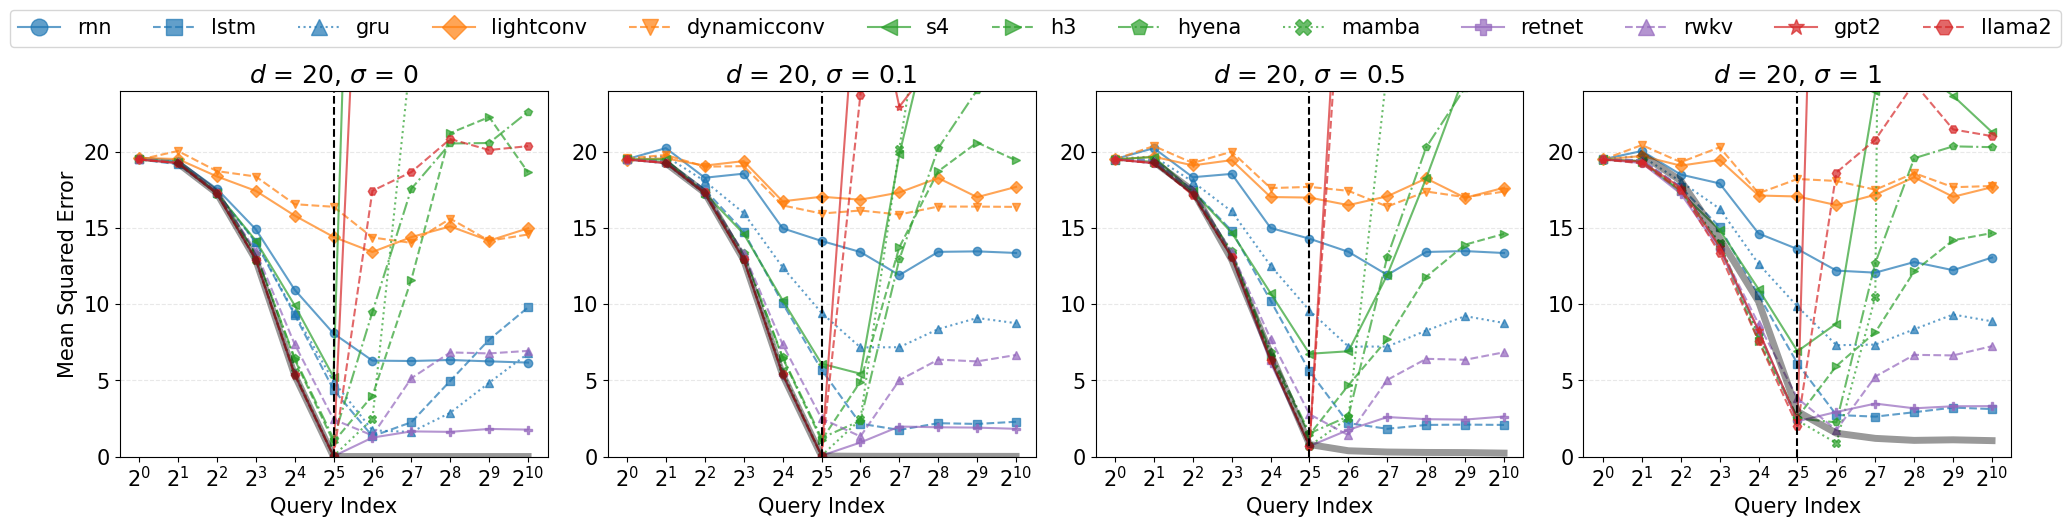

In [19]:
def plot(ax, df, n_classes=2, val_test='val', is_first_subplot=False):
    
    if val_test == 'val':
        col_to_plot = 'val_tok_pow2'
    elif val_test == 'test':
        col_to_plot = 'test_tok_pow2'
    else:
        raise ValueError(f"Invalid val_test: {val_test}")

    # filter df to only include n_classes
    train_noise, val_noise = n_classes
    df = df[(df['data.train_noise'] == train_noise) & (df['data.val_noise'] == val_noise)]

    if val_noise == 0:
        # load df_agg_lr_20.pkl
        df = pd.read_pickle("df_agg_lr_20.pkl")

    for model in legend_order:
    # for idx, row in df.iterrows():
        row = df[df['model'] == model].iloc[0]
        # model = row['model']
        style_args = style_map[model]
        ax.plot(
            row[col_to_plot],
            label=f"{row['model']}",
            alpha=0.7,
            **style_args,
        )

    baseline = {
        0: [np.nan, 19.27738, 17.31752, 12.93573, 5.3514, 9e-05, 0.0, 0.0, 0.0, 0.0, 0.0],
        0.1: [np.nan, 19.28091, 17.34021, 12.9282, 5.36886, 0.03235, 0.01582, 0.0114, 0.01105, 0.01059, 0.00984],
        0.5: [np.nan, 19.37214, 17.46724, 12.93289, 6.7547, 0.7899, 0.37879, 0.2961, 0.26814, 0.25995, 0.22406],
        1: [np.nan, 19.83853, 18.1252, 14.33715, 10.18441, 2.95707, 1.53267, 1.19319, 1.06155, 1.09832, 1.04402]
    }
    ax.plot(baseline[val_noise], color="black", linestyle="-", alpha=0.4, linewidth=5)

    # draw a dotted vertical line at n_xy_train
    v_idx = int(np.log2(row[XYS_TRAIN]))
    ax.axvline(x=v_idx, linestyle="--", color="black")

    # Add faint horizontal grid lines
    ax.yaxis.grid(True, linestyle="--", which="major", color="lightgrey", alpha=0.5)

    # Set x axis to powers of 2^0 ... 2^10
    ax.set_xticks(range(0, 11))
    ax.set_xticklabels([f"$2^{{{i}}}$" for i in range(11)])

    # set y axis scale
    ax.set_ylim(0, 20*1.2)


    # set title and labels
    title = f"task={project.split('-')[0]}, split={val_test}, classes={n_classes}, train_xys={row[XYS_TRAIN]}, step={STEP}, runs={TOP_K_RUNS}"
    print(title)
    ax.set_xlabel("Query Index")
    # Set y-axis label only on the first subplot
    if is_first_subplot:
        ax.set_ylabel(METRIC)

    title = f"$d$ = 20, $\sigma$ = {n_classes[1]}"
    ax.set_title(title)

plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(1, len(n_classes), figsize=(20, 5))
# Use the plot function inside a loop for all class counts you want to plot
for i, n_class in enumerate(n_classes):
    plot(axes[i], df_agg, n_classes=n_class, val_test='test', is_first_subplot=(i==0))  # Pass the appropriate axes

handles, labels = axes[0].get_legend_handles_labels()
# for h in handles:
#     h.set_markersize(5)
fig.legend(handles, labels, loc='upper center', ncol=len(df_agg['model'].unique()), bbox_to_anchor=(0.5, 1.08), markerscale=2)
# make the markers larger in the legend

plt.tight_layout()
plt.show()

task=lr, split=test, classes=(0, 0), train_xys=32, step=last, runs=1
task=lr, split=test, classes=(0, 0.1), train_xys=32, step=last, runs=1
task=lr, split=test, classes=(0, 0.5), train_xys=32, step=last, runs=1
task=lr, split=test, classes=(0, 1), train_xys=32, step=last, runs=1


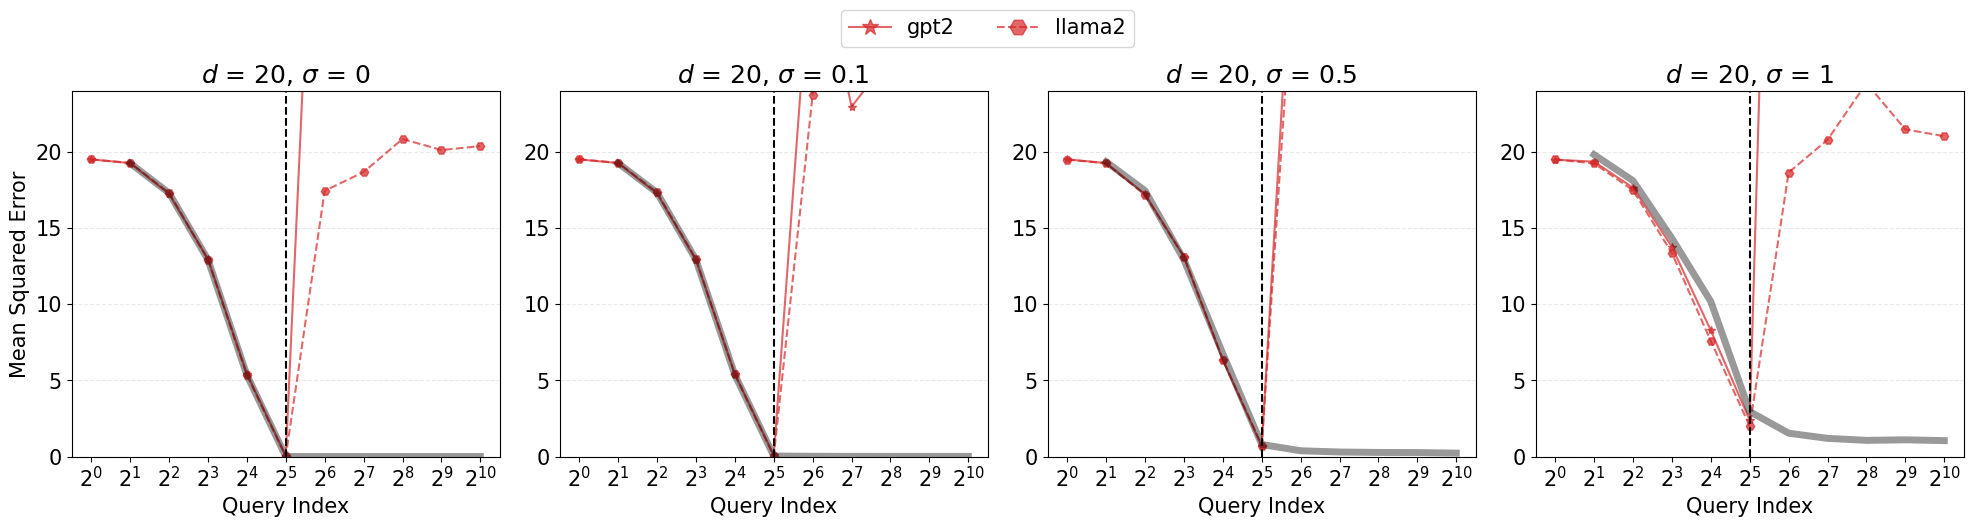

task=lr, split=test, classes=(0, 0), train_xys=32, step=last, runs=1
task=lr, split=test, classes=(0, 0.1), train_xys=32, step=last, runs=1
task=lr, split=test, classes=(0, 0.5), train_xys=32, step=last, runs=1
task=lr, split=test, classes=(0, 1), train_xys=32, step=last, runs=1


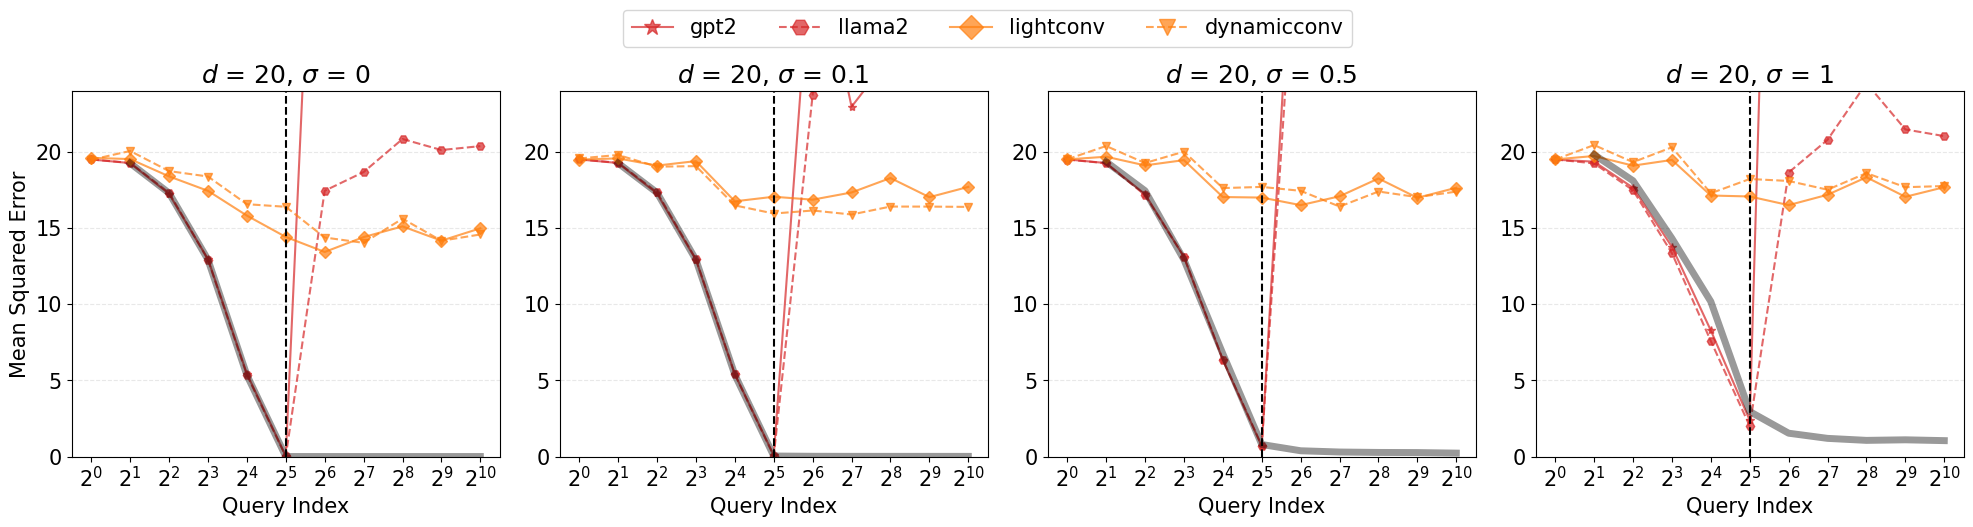

task=lr, split=test, classes=(0, 0), train_xys=32, step=last, runs=1
task=lr, split=test, classes=(0, 0.1), train_xys=32, step=last, runs=1
task=lr, split=test, classes=(0, 0.5), train_xys=32, step=last, runs=1
task=lr, split=test, classes=(0, 1), train_xys=32, step=last, runs=1


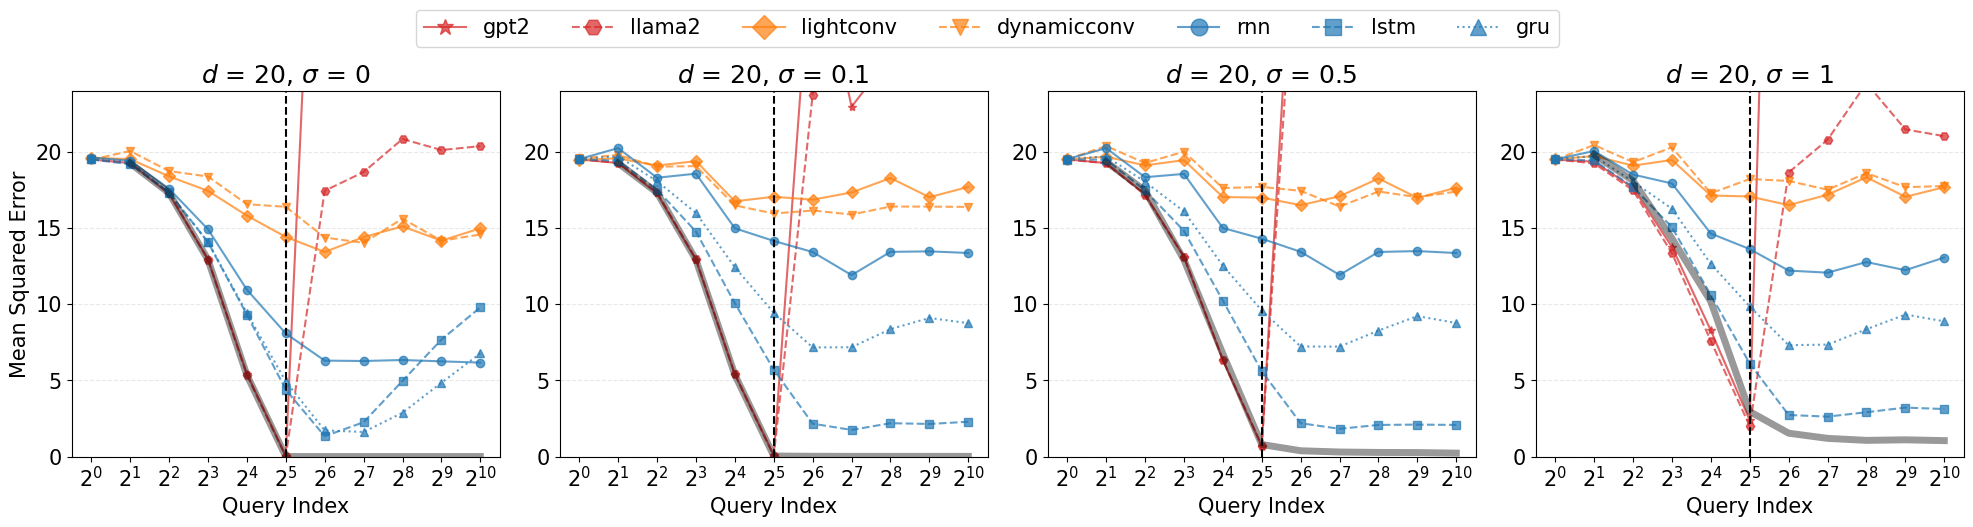

task=lr, split=test, classes=(0, 0), train_xys=32, step=last, runs=1
task=lr, split=test, classes=(0, 0.1), train_xys=32, step=last, runs=1
task=lr, split=test, classes=(0, 0.5), train_xys=32, step=last, runs=1
task=lr, split=test, classes=(0, 1), train_xys=32, step=last, runs=1


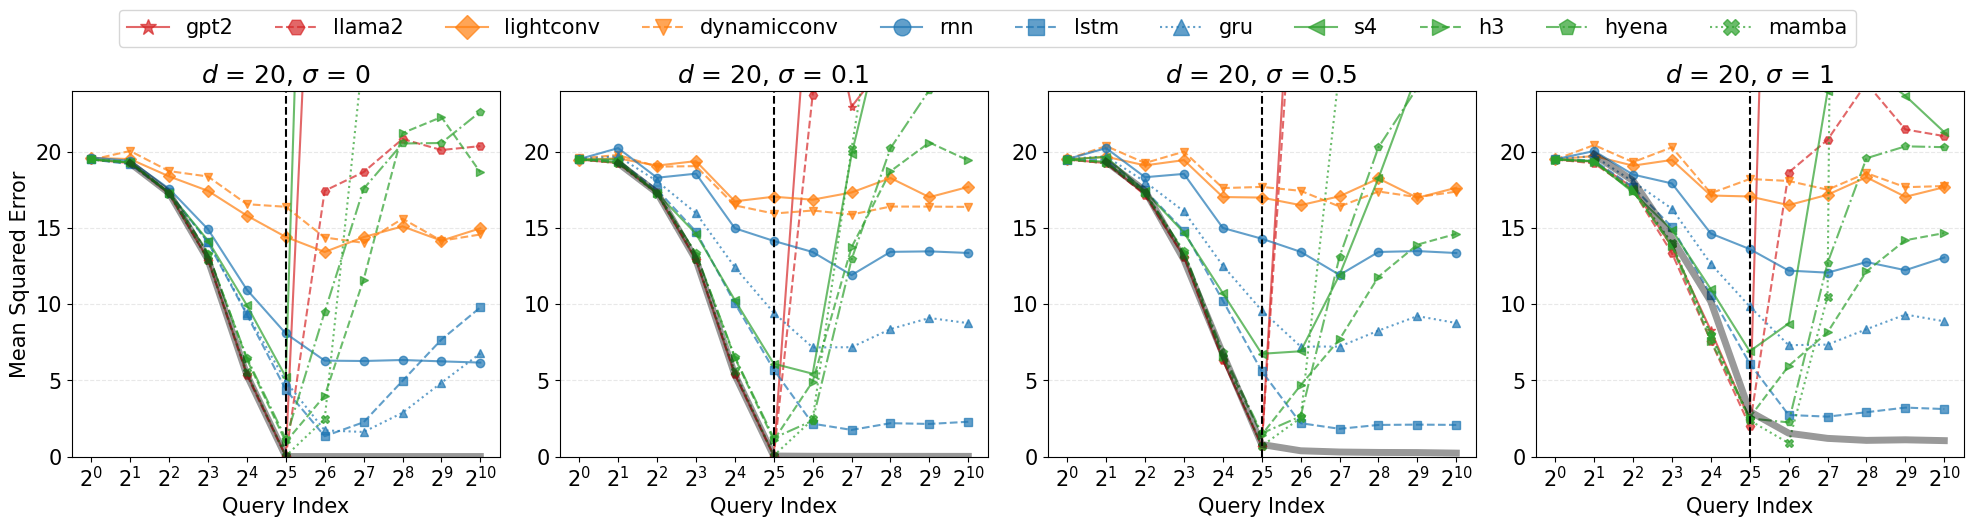

task=lr, split=test, classes=(0, 0), train_xys=32, step=last, runs=1
task=lr, split=test, classes=(0, 0.1), train_xys=32, step=last, runs=1
task=lr, split=test, classes=(0, 0.5), train_xys=32, step=last, runs=1
task=lr, split=test, classes=(0, 1), train_xys=32, step=last, runs=1


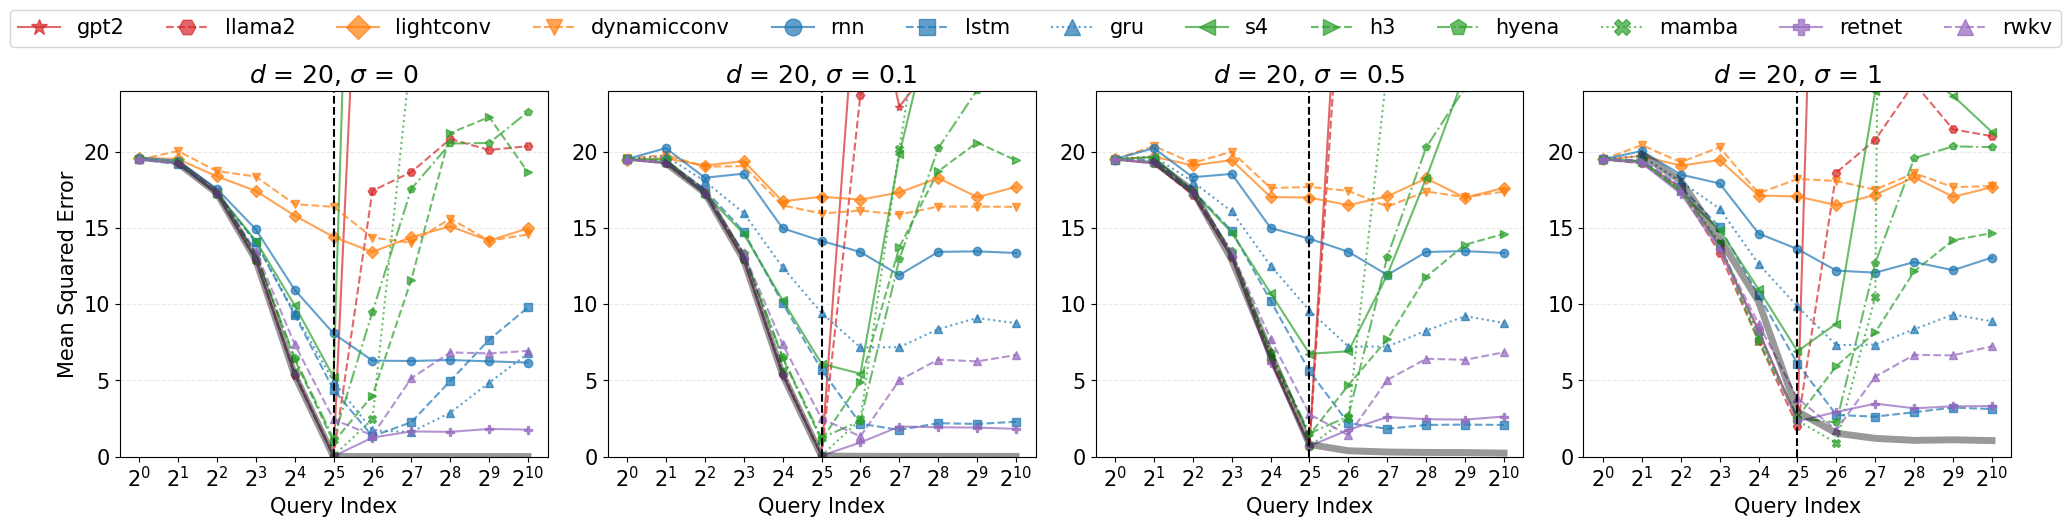

In [20]:
transformers = ['gpt2', 'llama2']
rnns = ['rnn', 'lstm', 'gru']
cnns = ['lightconv', 'dynamicconv']
ssms = ['s4', 'h3', 'hyena', 'mamba']
attalts = ['retnet', 'rwkv']
legend_order = []
for family in [transformers, cnns, rnns, ssms, attalts]:
    legend_order += family

    plt.rcParams.update({'font.size': 15})
    fig, axes = plt.subplots(1, len(n_classes), figsize=(20, 5))
    # Use the plot function inside a loop for all class counts you want to plot
    for i, n_class in enumerate(n_classes):
        plot(axes[i], df_agg, n_classes=n_class, val_test='test', is_first_subplot=(i==0))  # Pass the appropriate axes

    handles, labels = axes[0].get_legend_handles_labels()
    # for h in handles:
    #     h.set_markersize(5)
    fig.legend(handles, labels, loc='upper center', ncol=len(df_agg['model'].unique()), bbox_to_anchor=(0.5, 1.08), markerscale=2)
    # make the markers larger in the legend

    plt.tight_layout()
    plt.show()

task=lr, split=test, classes=(0, 0), step=last, runs=1


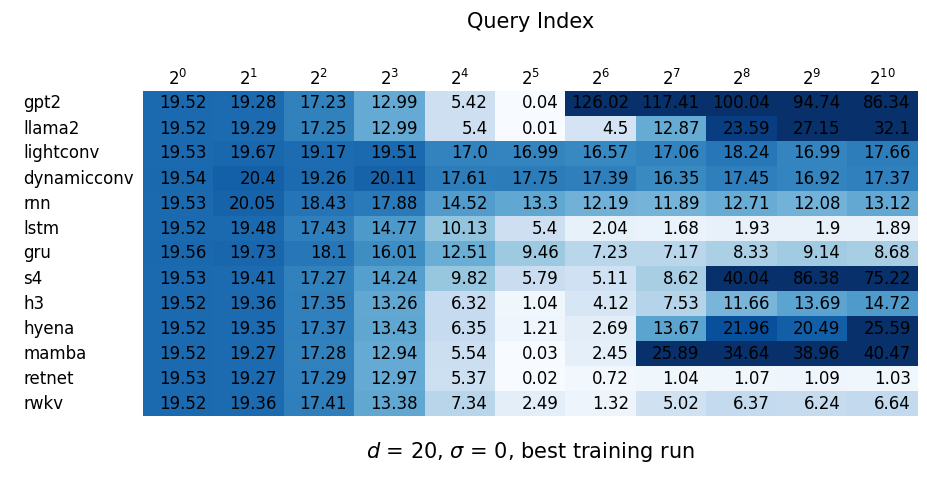

task=lr, split=test, classes=(0, 0.1), step=last, runs=1


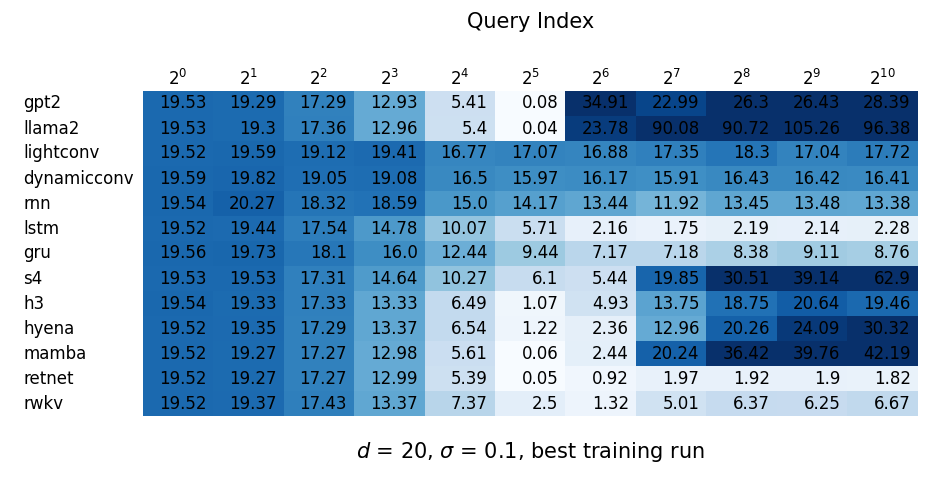

task=lr, split=test, classes=(0, 0.5), step=last, runs=1


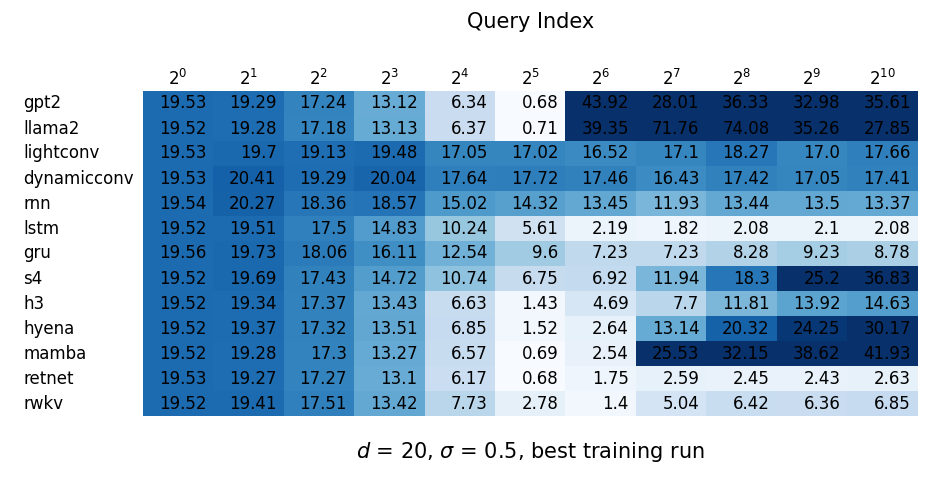

task=lr, split=test, classes=(0, 1), step=last, runs=1


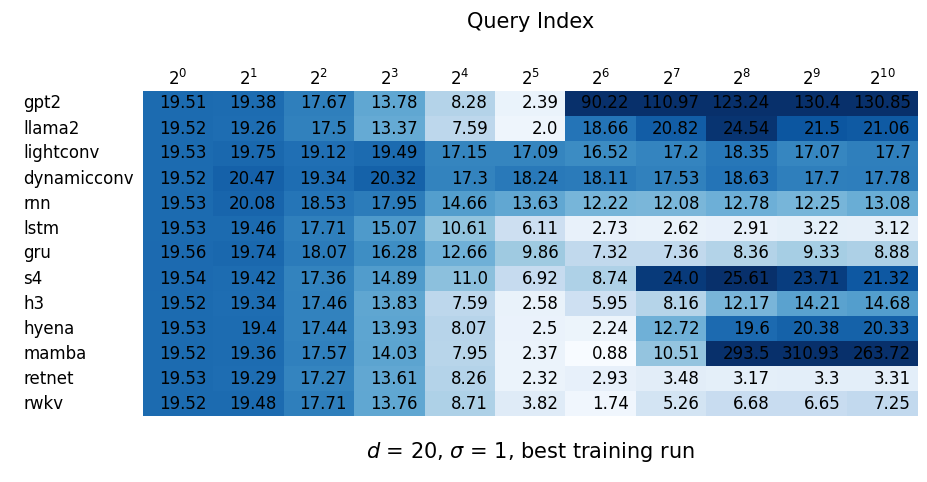

In [21]:
def acc_vs_tkn_idx(df, n_classes=20):
    # Filter dataframe for the given number of classes and make a copy to avoid SettingWithCopyWarning
    train_noise, val_noise = n_classes
    df_filtered = df[(df['data.train_noise'] == train_noise) & (df['data.val_noise'] == val_noise)].copy()
    # df_filtered = df[df[DIFF] == n_classes].copy()

    # Perform operations on the copy to compute lengths and average accuracies
    df_filtered.loc[:, 'val_tok_len'] = df_filtered[METRIC_TOK_VAL].str.len()
    df_filtered.loc[:, 'test_tok_len'] = df_filtered[METRIC_TOK_TEST].str.len()
    
    # Extract power of 2 accuracies and compute lengths
    df_filtered.loc[:, 'val_tok_pow2'] = df_filtered[METRIC_TOK_VAL].apply(extract_pow2_accs)
    df_filtered.loc[:, 'test_tok_pow2'] = df_filtered[METRIC_TOK_TEST].apply(extract_pow2_accs)

    # Compute average accuracies
    df_filtered.loc[:, 'val_avg_acc'] = df_filtered[METRIC_TOK_VAL].apply(compute_avg_acc)
    df_filtered.loc[:, 'test_avg_acc'] = df_filtered[METRIC_TOK_TEST].apply(compute_avg_acc)

    # Determine the max length for token indices to set table column size
    max_len = df_filtered['test_tok_pow2_len'].max()
    df_new = pd.DataFrame(index=range(max_len))

    # Populate new dataframe with accuracy data for each model
    for m in df_filtered['model'].unique():
        model_data = df_filtered[df_filtered['model'] == m]['test_tok_pow2'].iloc[0]
        temp_series = pd.Series(model_data, index=df_new.index, name=m)
        df_new = df_new.join(temp_series)  # Join the series to the dataframe

    # Round values and transpose the dataframe for plotting
    df_new_rounded = df_new.transpose().round(2)

    # sort rows by legend_order
    df_new_sorted = df_new_rounded.reindex(legend_order)


    # Sort the models by a specific token index accuracy
    # df_new_sorted = df_new_rounded.sort_values(by=5, ascending=True if METRIC_MAX_MIN == 'min' else False)

    # Plot the table with a heatmap
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('off')
    col_labels = [f"$2^{{{i}}}$" for i in range(max_len)]  # Updated column labels
    cm = plt.cm.Blues if METRIC_MAX_MIN == 'min' else plt.cm.Blues_r
    the_table = ax.table(cellText=df_new_sorted.values,
                         colLabels=col_labels,  # Use updated column labels here
                         rowLabels=df_new_sorted.index,
                         loc='center',
                         cellColours=cm(normalize(df_new_sorted.values)),
                         )
    the_table.auto_set_font_size(True)
    the_table.set_fontsize(12)
    the_table.scale(1, 1.5)

    # Set the cell borders to transparent
    for key, cell in the_table.get_celld().items():
        cell.set_edgecolor('none')
        # add horizontal lines to separate col labels from table
        # if key[0] == 0:
        #     cell.set_edgecolor('black')
        #     # only set line on bottom edge
        #     cell.set_linewidth(2)
        #     cell.set_linestyle('--')
        # add vertical lines to separate row labels from table


    title = f"task={project.split('-')[0]}, split=test, classes={n_classes}, step={STEP}, runs={TOP_K_RUNS}"
    
    print(title)
    # make clear that columns are query indices
    ax.text(0.5, 0.96, "Query Index", transform=ax.transAxes, ha="center", fontsize=15)

    if TOP_K_RUNS == 1:
        suff = ", best training run"
    else:
        suff = f", average over all training runs"

    if project == 'lr-extrapolate-noisy2':
        title = f"$d$ = 20, $\sigma$ = {val_noise}" + suff
    elif project == 'ar-extrapolate':
        title = f"$|V|={n_classes}$" + suff
    elif project == 'gmm-extrapolate':
        title = f"$k={n_classes}$" + suff
    ax.text(0.5, 0.03, title, transform=ax.transAxes, ha="center", fontsize=15)

    plt.show()
    return df_new_sorted

# Normalization function for colormap
def normalize(arr):
    norm = plt.Normalize(vmin=arr.min(), vmax=min(arr.max(), 25))
    return norm(arr)

# Call the function with your dataframe and the specified number of classes
for n in n_classes:
    acc_vs_tkn_idx(df_agg, n_classes=n)


In [22]:
# compute monotonicity for each curve
def compute_monotonicity(x, eps, start_idx=0, max_idx=12):
    x = x[start_idx:max_idx]
    return np.sum((np.diff(x) + eps) > 0) / (len(x) - 1)

eps = 0.0001

df_agg['val_mono'] = df_agg['val_tok_pow2'].apply(compute_monotonicity, eps=eps)
df_agg['test_mono'] = df_agg['test_tok_pow2'].apply(compute_monotonicity, eps=eps)
df_agg['val_mono_no_extrap'] = df_agg['val_tok_pow2'].apply(compute_monotonicity, eps=eps, max_idx=6)
df_agg['test_mono_no_extrap'] = df_agg['test_tok_pow2'].apply(compute_monotonicity, eps=eps, max_idx=6)
df_agg['val_mono_extrap'] = df_agg['val_tok_pow2'].apply(compute_monotonicity, eps=eps, start_idx=6)
df_agg['test_mono_extrap'] = df_agg['test_tok_pow2'].apply(compute_monotonicity, eps=eps, start_idx=6)

def compute_avg_acc(x, start_idx=0, max_idx=12):
    x = x[start_idx:max_idx]
    return np.mean(x)

# compute avg accuracies before and after extrapolation phase
df_agg['test_acc'] = df_agg['test_tok_pow2'].apply(compute_avg_acc)
df_agg['test_acc_no_extrap'] = df_agg['test_tok_pow2'].apply(compute_avg_acc, max_idx=6)
df_agg['test_acc_extrap'] = df_agg['test_tok_pow2'].apply(compute_avg_acc, start_idx=6)


df_agg[['model', 'data.num_classes','test_avg_acc', 'test_mono', 'test_mono_no_extrap', 'test_mono_extrap', 'test_acc', 'test_acc_no_extrap', 'test_acc_extrap']]

KeyError: "['data.num_classes'] not in index"

Observation: recurrent + rwkv are the most monotonic, followed by convolutions, then the remaining att alts and transformers

In [ ]:
# group df_agg by num_classes with a final group thats the average of all groups
df_agg_grouped = df_agg.groupby(["model"])
# average by test_monotonicity
df_agg_grouped = df_agg_grouped.agg(
    {
        "test_mono": ["mean", "std"],
        "test_mono_no_extrap": ["mean", "std"],
        "test_mono_extrap": ["mean", "std"],
        "test_acc": ["mean", "std"],
        "test_acc_no_extrap": ["mean", "std"],
        "test_acc_extrap": ["mean", "std"],
    }
)
df_agg_grouped = df_agg_grouped.reset_index()
df_agg_grouped.sort_values(by=[("test_mono", "mean")], ascending=False)

model test_mono           test_mono_no_extrap           \
                     mean       std                mean      std   
2           gru  0.766667  0.115470            1.000000  0.00000   
11         rwkv  0.766667  0.057735            1.000000  0.00000   
7          lstm  0.733333  0.057735            1.000000  0.00000   
10          rnn  0.733333  0.057735            0.933333  0.11547   
0   dynamicconv  0.666667  0.152753            0.866667  0.23094   
5     lightconv  0.666667  0.152753            0.866667  0.23094   
4         hyena  0.566667  0.057735            1.000000  0.00000   
8         mamba  0.566667  0.057735            1.000000  0.00000   
9        retnet  0.566667  0.057735            1.000000  0.00000   
12           s4  0.566667  0.057735            0.933333  0.11547   
3            h3  0.533333  0.057735            1.000000  0.00000   
6        llama2  0.533333  0.057735            1.000000  0.00000   
1          gpt2  0.500000  0.000000            1.000000  0.00000   

   test_mono_extrap            test_acc           test_acc_no_extrap  \
               mean       std      mean       std               mean   
2          0.500000  0.250000  0.436629  0.293964           0.401772   
11         0.500000  0.000000  0.655097  0.202677           0.541391   
7          0.416667  0.144338  0.413829  0.253550           0.383147   
10         0.416667  0.288675  0.457864  0.336442           0.425441   
0          0.500000  0.000000  0.442616  0.325562           0.410344   
5          0.416667  0.144338  0.423827  0.323592           0.397758   
4          0.000000  0.000000  0.521437  0.249076           0.521107   
8          0.000000  0.000000  0.610018  0.202724           0.542862   
9          0.166667  0.144338  0.562794  0.305390           0.519152   
12         0.083333  0.144338  0.410176  0.300081           0.402915   
3          0.000000  0.000000  0.576354  0.234638           0.527025   
6          0.000000  0.000000  0.536156  0.244150           0.539706   
1          0.000000  0.000000  0.506380  0.310418           0.500652   

             test_acc_extrap            
         std            mean       std  
2   0.278946        0.478457  0.312321  
11  0.239806        0.791543  0.160149  
7   0.245094        0.450648  0.264500  
10  0.310328        0.496772  0.367919  
0   0.299203        0.481343  0.357538  
5   0.297599        0.455109  0.354809  
4   0.266467        0.521832  0.228305  
8   0.238908        0.690605  0.162592  
9   0.275494        0.615163  0.342130  
12  0.292137        0.418889  0.309637  
3   0.260529        0.635548  0.208705  
6   0.242556        0.531896  0.246078  
1   0.302165        0.513254  0.320383

In [ ]:
df_agg_grouped.sort_values(by=[("test_acc", "mean")], ascending=False)

model test_mono           test_mono_no_extrap           \
                     mean       std                mean      std   
11         rwkv  0.766667  0.057735            1.000000  0.00000   
8         mamba  0.566667  0.057735            1.000000  0.00000   
3            h3  0.533333  0.057735            1.000000  0.00000   
9        retnet  0.566667  0.057735            1.000000  0.00000   
6        llama2  0.533333  0.057735            1.000000  0.00000   
4         hyena  0.566667  0.057735            1.000000  0.00000   
1          gpt2  0.500000  0.000000            1.000000  0.00000   
10          rnn  0.733333  0.057735            0.933333  0.11547   
0   dynamicconv  0.666667  0.152753            0.866667  0.23094   
2           gru  0.766667  0.115470            1.000000  0.00000   
5     lightconv  0.666667  0.152753            0.866667  0.23094   
7          lstm  0.733333  0.057735            1.000000  0.00000   
12           s4  0.566667  0.057735            0.933333  0.11547   

   test_mono_extrap            test_acc           test_acc_no_extrap  \
               mean       std      mean       std               mean   
11         0.500000  0.000000  0.655097  0.202677           0.541391   
8          0.000000  0.000000  0.610018  0.202724           0.542862   
3          0.000000  0.000000  0.576354  0.234638           0.527025   
9          0.166667  0.144338  0.562794  0.305390           0.519152   
6          0.000000  0.000000  0.536156  0.244150           0.539706   
4          0.000000  0.000000  0.521437  0.249076           0.521107   
1          0.000000  0.000000  0.506380  0.310418           0.500652   
10         0.416667  0.288675  0.457864  0.336442           0.425441   
0          0.500000  0.000000  0.442616  0.325562           0.410344   
2          0.500000  0.250000  0.436629  0.293964           0.401772   
5          0.416667  0.144338  0.423827  0.323592           0.397758   
7          0.416667  0.144338  0.413829  0.253550           0.383147   
12         0.083333  0.144338  0.410176  0.300081           0.402915   

             test_acc_extrap            
         std            mean       std  
11  0.239806        0.791543  0.160149  
8   0.238908        0.690605  0.162592  
3   0.260529        0.635548  0.208705  
9   0.275494        0.615163  0.342130  
6   0.242556        0.531896  0.246078  
4   0.266467        0.521832  0.228305  
1   0.302165        0.513254  0.320383  
10  0.310328        0.496772  0.367919  
0   0.299203        0.481343  0.357538  
2   0.278946        0.478457  0.312321  
5   0.297599        0.455109  0.354809  
7   0.245094        0.450648  0.264500  
12  0.292137        0.418889  0.309637

In [ ]:
# Define a list of line styles, colors, and markers to cycle through
line_styles = ["-", "--", "-.", ":"]
colors = plt.cm.tab10(np.linspace(0, 1, 10))  # 10 distinct colors, can adjust as needed
markers = ["o", "s", "^", "D", "v", "<", ">", "p", "*", "+"]

# Use itertools.cycle to create an infinite loop over styles, colors, and markers
line_styles_cycle = itertools.cycle(line_styles)
colors_cycle = itertools.cycle(colors)
markers_cycle = itertools.cycle(markers)

# Mapping for n_classes to evenly spaced x-coordinates
mapping = {2: 1, 4: 2, 8: 3}
df_agg['x_coords'] = df_agg['data.num_classes'].map(mapping)

plt.figure(figsize=(10, 6))

offset_amount = 0.002

# Group by model and plot each group
for i, (model, group) in enumerate(df_agg.groupby('model')):
    offset_x = group['x_coords'] + i * offset_amount
    # offset_y = group['test_monotonicity'] + i * offset_amount
    plt.plot(
        offset_x,
        # group['x_coords'],
        # offset_y,
        group['test_monotonicity'],
        label=model,
        linestyle=next(line_styles_cycle),
        color=next(colors_cycle),
        marker=next(markers_cycle),
        alpha=0.6
    )

plt.title('Test Monotonicity of Models Across Different Numbers of Classes')
plt.xlabel('Number of Classes')
plt.ylabel('Test Monotonicity')
plt.xticks(list(mapping.values()), list(mapping.keys()))  # Set x-ticks to reflect original values
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
plt.show()

KeyError: 'test_monotonicity'

<Figure size 1000x600 with 0 Axes>

In [ ]:
succ_thresh = {2: 0.8, 4: 0.7, 8: 0.6}
idx_of_int = [3, 5, 7]
idx_of_int = [int(2**i-1) for i in idx_of_int]
idx_of_int

In [ ]:
def compute_success(row, succ_thresh, idx_of_int):
    thresh = succ_thresh[row['n_classes']]
    # get the accuracy at the index of interest
    acc = row['per_token_acc'][idx_of_int]
    # row['acc_of_int'] = acc
    row['success'] = acc >= thresh
    return row

succ_runs = best_runs.apply(lambda x: compute_success(x, succ_thresh, idx_of_int), axis=1)
succ_runs.success

In [ ]:
def check_monotonicity(row, idx_of_int, epsilon=1e-5):
    acc = row['per_token_acc'][idx_of_int]
    # check if acc is monotonic
    is_monotonic = np.all(np.diff(acc) >= -epsilon)
    row['monotonic'] = is_monotonic
    return row

mono_runs = succ_runs.apply(lambda x: check_monotonicity(x, idx_of_int), axis=1)
mono_runs.monotonic